In [27]:
import pandas as pd
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [28]:
# load data
df = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/tracking_data/tracking_week_1.csv')
games = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/games.csv')
plays = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/plays.csv')

In [29]:
df['event'].unique()

array([nan, 'pass_arrived', 'pass_outcome_caught', 'tackle', 'run',
       'first_contact', 'ball_snap', 'handoff', 'touchdown',
       'out_of_bounds', 'man_in_motion', 'fumble', 'play_action',
       'pass_forward', 'lateral', 'autoevent_passforward',
       'autoevent_passinterrupted', 'line_set', 'qb_slide', 'shift',
       'run_pass_option', 'qb_sack', 'pass_shovel', 'autoevent_ballsnap',
       'snap_direct', 'fumble_defense_recovered',
       'fumble_offense_recovered'], dtype=object)

In [30]:
df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event'],
      dtype='object')

In [31]:
# Function to calculate Euclidean distance
def calculate_distance(row, ball_position):
    return np.sqrt((ball_position['x'] - row['x'])**2 + (ball_position['y'] - row['y'])**2)

def create_feature_space(frame_df):
    # Extract gameId, playId, and frameId
    gameId = frame_df['gameId'].iloc[0]
    playId = frame_df['playId'].iloc[0]
    frameId = frame_df['frameId'].iloc[0]

    # Split into offense and defense
    offense = frame_df[frame_df['OFF'] == True].sort_values('distance_to_ball')
    defense = frame_df[frame_df['OFF'] == False].sort_values('distance_to_ball')

    # Initialize a dictionary to hold the features
    features = {'gameId': gameId, 'playId': playId, 'frameId': frameId}
    
    # Extract features for individual offensive players
    for i, player in enumerate(offense.itertuples(), start=1):
        features[f'OFF_PLAYER_{i}_X'] = player.x
        features[f'OFF_PLAYER_{i}_Y'] = player.y
        features[f'OFF_PLAYER_{i}_A'] = player.a
        features[f'OFF_PLAYER_{i}_S'] = player.s
        features[f'OFF_PLAYER_{i}_D'] = player.distance_to_ball

    # Extract features for individual defensive players
    for i, player in enumerate(defense.itertuples(), start=1):
        features[f'DEF_PLAYER_{i}_X'] = player.x
        features[f'DEF_PLAYER_{i}_Y'] = player.y
        features[f'DEF_PLAYER_{i}_A'] = player.a
        features[f'DEF_PLAYER_{i}_S'] = player.s
        features[f'DEF_PLAYER_{i}_D'] = player.distance_to_ball

    # Aggregating offensive player features
    for feature in ['x', 'y', 'a', 's', 'distance_to_ball']:
        features[f'OFF_{feature}_sum'] = offense[feature].sum()
        features[f'OFF_{feature}_avg'] = offense[feature].mean()
        features[f'DEF_{feature}_std'] = offense[feature].std()
        features[f'OFF_{feature}_min'] = offense[feature].min()
        features[f'OFF_{feature}_max'] = offense[feature].max()
        features[f'DEF_{feature}_range'] = offense[feature].max()- offense[feature].min()

    # Aggregating defensive player features
    for feature in ['a', 's', 'distance_to_ball']:
        features[f'DEF_{feature}_sum'] = defense[feature].sum()
        features[f'DEF_{feature}_avg'] = defense[feature].mean()
        features[f'DEF_{feature}_std'] = defense[feature].std()
        features[f'DEF_{feature}_min'] = defense[feature].min()
        features[f'DEF_{feature}_max'] = defense[feature].max()
        features[f'DEF_{feature}_range'] = defense[feature].max()- defense[feature].min()


    return features

def create_dataset(df, game_id):
    plays_filtered = plays.copy()[['gameId', 'playId', 'possessionTeam', 'defensiveTeam']]
    df = df.merge(plays_filtered, on=['gameId', 'playId'], how='left')
    df['OFF'] = df['possessionTeam'] == df['club']

    # filter for game id for training or testing
    df = df[df['gameId'] == game_id]

    # Initialize an empty list to store feature spaces for all frames
    all_feature_spaces = []

    # Iterate over each unique game and play
    for (gameId, playId), group in df.groupby(['gameId', 'playId']):
        # Filter rows for the ball carrier in this game and play
        ball_df = group[group['displayName'] == 'football']

        # Calculate distances for each frame in this game and play
        for frame in group['frameId'].unique():
            ball_position = ball_df[ball_df['frameId'] == frame].iloc[0]
            frame_df = group[group['frameId'] == frame]
            group.loc[group['frameId'] == frame, 'distance_to_ball'] = frame_df.apply(lambda row: calculate_distance(row, ball_position), axis=1)

        # Create feature space for each frame
        feature_space = [create_feature_space(group[group['frameId'] == frame]) for frame in group['frameId'].unique()]
        all_feature_spaces.extend(feature_space)

    # Convert to DataFrame
    feature_space_df = pd.DataFrame(all_feature_spaces)

    # setting the target var
    # Identify frames where tackles occur
    tackle_frames = df.loc[(df['displayName'] == 'football') & (df['event'] == 'tackle') | (df['event'] == 'first_contact'), ['gameId', 'playId', 'frameId']]

    # Merge with feature_space_df to align the frames
    final_df = feature_space_df.merge(tackle_frames, on=['gameId', 'playId', 'frameId'], how='left', indicator=True)

    # Create the binary target variable
    # If '_merge' is 'both', then a tackle occurred in that frame
    final_df['contact_or_tackle_happened'] = np.where(final_df['_merge'] == 'both', 1, 0)

    # Drop the '_merge' column as it's no longer needed
    final_df.drop(columns=['_merge'], inplace=True)

    # Extract the list of feature columns (excluding the target variable)
    features_list = final_df.columns[3:-1].tolist()  # Adjust the slicing based on your DataFrame

    return final_df, features_list

In [32]:
final_df, features_list = create_dataset(df, game_id=2022091101)

In [33]:
features_list

['OFF_PLAYER_1_X',
 'OFF_PLAYER_1_Y',
 'OFF_PLAYER_1_A',
 'OFF_PLAYER_1_S',
 'OFF_PLAYER_1_D',
 'OFF_PLAYER_2_X',
 'OFF_PLAYER_2_Y',
 'OFF_PLAYER_2_A',
 'OFF_PLAYER_2_S',
 'OFF_PLAYER_2_D',
 'OFF_PLAYER_3_X',
 'OFF_PLAYER_3_Y',
 'OFF_PLAYER_3_A',
 'OFF_PLAYER_3_S',
 'OFF_PLAYER_3_D',
 'OFF_PLAYER_4_X',
 'OFF_PLAYER_4_Y',
 'OFF_PLAYER_4_A',
 'OFF_PLAYER_4_S',
 'OFF_PLAYER_4_D',
 'OFF_PLAYER_5_X',
 'OFF_PLAYER_5_Y',
 'OFF_PLAYER_5_A',
 'OFF_PLAYER_5_S',
 'OFF_PLAYER_5_D',
 'OFF_PLAYER_6_X',
 'OFF_PLAYER_6_Y',
 'OFF_PLAYER_6_A',
 'OFF_PLAYER_6_S',
 'OFF_PLAYER_6_D',
 'OFF_PLAYER_7_X',
 'OFF_PLAYER_7_Y',
 'OFF_PLAYER_7_A',
 'OFF_PLAYER_7_S',
 'OFF_PLAYER_7_D',
 'OFF_PLAYER_8_X',
 'OFF_PLAYER_8_Y',
 'OFF_PLAYER_8_A',
 'OFF_PLAYER_8_S',
 'OFF_PLAYER_8_D',
 'OFF_PLAYER_9_X',
 'OFF_PLAYER_9_Y',
 'OFF_PLAYER_9_A',
 'OFF_PLAYER_9_S',
 'OFF_PLAYER_9_D',
 'OFF_PLAYER_10_X',
 'OFF_PLAYER_10_Y',
 'OFF_PLAYER_10_A',
 'OFF_PLAYER_10_S',
 'OFF_PLAYER_10_D',
 'OFF_PLAYER_11_X',
 'OFF_PLAYER_11_Y',
 'OFF

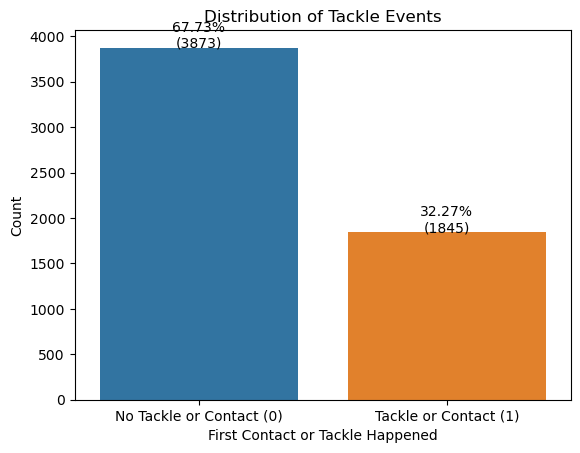

In [34]:

# Count the occurrences of each category
tackle_counts = final_df['contact_or_tackle_happened'].value_counts()
total = len(final_df['contact_or_tackle_happened'])

# Create a bar plot
sns.barplot(x=tackle_counts.index, y=tackle_counts.values)
plt.title('Distribution of Tackle Events')
plt.xlabel('First Contact or Tackle Happened')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Tackle or Contact (0)', 'Tackle or Contact (1)'])

# Add percentages and counts above bars
for index, value in enumerate(tackle_counts):
    percentage = f'{(value / total) * 100:.2f}%'
    plt.text(index, value, f'{percentage}\n({value})', ha='center')

plt.show()

In [35]:
final_df.isnull().sum()

gameId                        0
playId                        0
frameId                       0
OFF_PLAYER_1_X                0
OFF_PLAYER_1_Y                0
                             ..
DEF_distance_to_ball_sum      0
DEF_distance_to_ball_avg      0
DEF_distance_to_ball_min      0
DEF_distance_to_ball_max      0
contact_or_tackle_happened    0
Length: 161, dtype: int64

In [36]:
X = final_df[features_list]

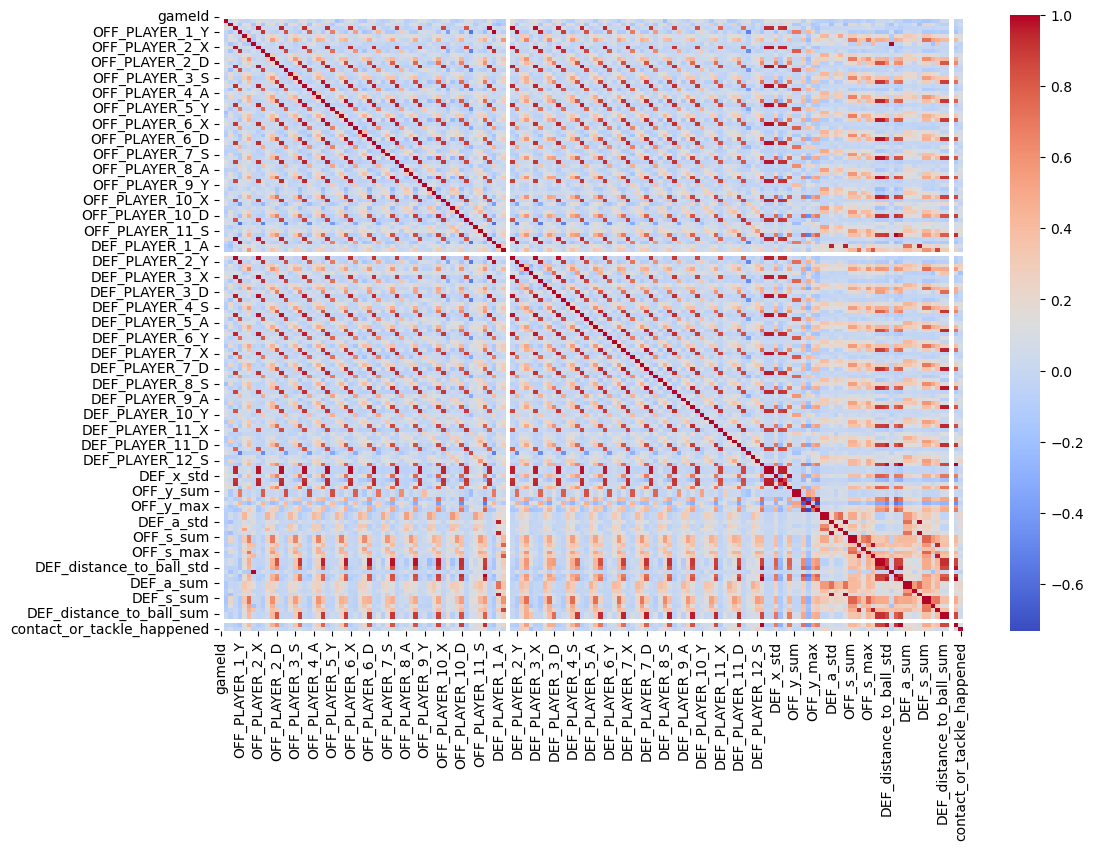

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = final_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [38]:
print('Training data set shape: ', final_df.shape)
print('Number of features: ', len(features_list))

Training data set shape:  (5718, 161)
Number of features:  157


In [39]:
final_df.columns

Index(['gameId', 'playId', 'frameId', 'OFF_PLAYER_1_X', 'OFF_PLAYER_1_Y',
       'OFF_PLAYER_1_A', 'OFF_PLAYER_1_S', 'OFF_PLAYER_1_D', 'OFF_PLAYER_2_X',
       'OFF_PLAYER_2_Y',
       ...
       'DEF_a_max', 'DEF_s_sum', 'DEF_s_avg', 'DEF_s_min', 'DEF_s_max',
       'DEF_distance_to_ball_sum', 'DEF_distance_to_ball_avg',
       'DEF_distance_to_ball_min', 'DEF_distance_to_ball_max',
       'contact_or_tackle_happened'],
      dtype='object', length=161)

In [40]:
# Separate identifiers
identifiers = final_df[['gameId', 'playId', 'frameId','contact_or_tackle_happened']]

In [41]:
final_df.head()

,gameId,playId,frameId,OFF_PLAYER_1_X,OFF_PLAYER_1_Y,OFF_PLAYER_1_A,OFF_PLAYER_1_S,OFF_PLAYER_1_D,OFF_PLAYER_2_X,OFF_PLAYER_2_Y,...,DEF_a_max,DEF_s_sum,DEF_s_avg,DEF_s_min,DEF_s_max,DEF_distance_to_ball_sum,DEF_distance_to_ball_avg,DEF_distance_to_ball_min,DEF_distance_to_ball_max,contact_or_tackle_happened
0,2022091101,85,1,27.40,30.37,3.05,2.03,3.260552,27.11,25.55,...,6.87,65.980000,5.498333,2.10,20.920000,140.322426,11.693536,0.0,23.490125,0
1,2022091101,85,2,27.34,30.54,2.96,1.69,2.284842,26.81,25.46,...,9.43,64.949999,5.412500,1.81,20.049999,143.580933,11.965078,0.0,25.180569,0
2,2022091101,85,3,27.28,30.70,2.43,1.54,2.590173,25.91,36.10,...,11.54,63.400000,5.283333,1.42,19.000000,149.989060,12.499088,0.0,26.887651,0
3,2022091101,85,4,25.95,36.58,3.18,4.76,3.077288,27.24,30.83,...,10.19,62.730000,5.227500,1.13,18.500000,154.822917,12.901910,0.0,28.152238,0
4,2022091101,85,5,25.95,37.03,3.71,4.35,1.957268,29.49,36.67,...,14.83,59.640000,4.970000,0.90,15.810000,160.515253,13.376271,0.0,29.589055,0


In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd



# Adding a constant to the model (for intercept)
X = add_constant(X)

# Calculating VIF for each feature
VIF_data = pd.DataFrame()
VIF_data['feature'] = X.columns
VIF_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(VIF_data)


/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                      feature         VIF
0                       const  134.939146
1              OFF_PLAYER_1_X         inf
2              OFF_PLAYER_1_Y         inf
3              OFF_PLAYER_1_A         inf
4              OFF_PLAYER_1_S         inf
..                        ...         ...
153                 DEF_s_max         inf
154  DEF_distance_to_ball_sum         inf
155  DEF_distance_to_ball_avg         inf
156  DEF_distance_to_ball_min         NaN
157  DEF_distance_to_ball_max         inf

[158 rows x 2 columns]


In [43]:
final_df.columns

Index(['gameId', 'playId', 'frameId', 'OFF_PLAYER_1_X', 'OFF_PLAYER_1_Y',
       'OFF_PLAYER_1_A', 'OFF_PLAYER_1_S', 'OFF_PLAYER_1_D', 'OFF_PLAYER_2_X',
       'OFF_PLAYER_2_Y',
       ...
       'DEF_a_max', 'DEF_s_sum', 'DEF_s_avg', 'DEF_s_min', 'DEF_s_max',
       'DEF_distance_to_ball_sum', 'DEF_distance_to_ball_avg',
       'DEF_distance_to_ball_min', 'DEF_distance_to_ball_max',
       'contact_or_tackle_happened'],
      dtype='object', length=161)

In [44]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Set up your estimator list with only the classifier
estimators = [
    ('clf', XGBClassifier(random_state=42))  # Customize the classifier as needed
]

# Create the pipeline
pipe = Pipeline(steps=estimators)

# You can now proceed with fitting your pipeline to


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import brier_score_loss, make_scorer


# Define your search space
search_space = {
    'clf__max_depth': [2, 3, 4, 5, 6, 7, 8],
    'clf__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0],
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__reg_alpha': [0, 1, 5, 10],
    'clf__reg_lambda': [0, 1, 5, 10],
    'clf__gamma': [0, 0.1, 0.5, 1, 5, 10]
}

# Define a custom scorer for RandomizedSearchCV
brier_scorer = make_scorer(brier_score_loss, needs_proba=True, greater_is_better=False)

# Setup RandomizedSearchCV with Brier scorer
opt = RandomizedSearchCV(pipe, param_distributions=search_space, 
                         n_iter=10, scoring=brier_scorer, cv=3, 
                         random_state=42)


In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Split data into features (X) and target (y)
X = final_df[features_list]
y = final_df['contact_or_tackle_happened']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model on the training data
opt.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)[:, 1]

# Predict probabilities on the test set
y_pred_proba = opt.predict_proba(X_test)[:, 1]

# Calculate the Brier score
test_brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"Brier Score on Test Set: {test_brier_score}")
y_pred = opt.predict(X_test)
print(classification_report(y_test, y_pred))

Brier Score on Test Set: 0.021052516905611104
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       777
           1       0.96      0.96      0.96       367

    accuracy                           0.97      1144
   macro avg       0.97      0.97      0.97      1144
weighted avg       0.97      0.97      0.97      1144



[14:58:01] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "clf__colsample_bylevel", "clf__colsample_bynode", "clf__colsample_bytree", "clf__gamma", "clf__learning_rate", "clf__max_depth", "clf__reg_alpha", "clf__reg_lambda", "clf__subsample" } are not used.

[0]	validation_0-logloss:0.50987	validation_1-logloss:0.51933
[1]	validation_0-logloss:0.39788	validation_1-logloss:0.41425
[2]	validation_0-logloss:0.32252	validation_1-logloss:0.34542
[3]	validation_0-logloss:0.27164	validation_1-logloss:0.29915
[4]	validation_0-logloss:0.23602	validation_1-logloss:0.26638


/Users/nick/.conda/envs/advanced_ds/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.20729	validation_1-logloss:0.23602
[6]	validation_0-logloss:0.18575	validation_1-logloss:0.21650
[7]	validation_0-logloss:0.17456	validation_1-logloss:0.20544
[8]	validation_0-logloss:0.15565	validation_1-logloss:0.19111
[9]	validation_0-logloss:0.13640	validation_1-logloss:0.17581
[10]	validation_0-logloss:0.12214	validation_1-logloss:0.16429
[11]	validation_0-logloss:0.11277	validation_1-logloss:0.15678
[12]	validation_0-logloss:0.10774	validation_1-logloss:0.15348
[13]	validation_0-logloss:0.10233	validation_1-logloss:0.15126
[14]	validation_0-logloss:0.09617	validation_1-logloss:0.14692
[15]	validation_0-logloss:0.08740	validation_1-logloss:0.14285
[16]	validation_0-logloss:0.07830	validation_1-logloss:0.13583
[17]	validation_0-logloss:0.07575	validation_1-logloss:0.13444
[18]	validation_0-logloss:0.07022	validation_1-logloss:0.13071
[19]	validation_0-logloss:0.06569	validation_1-logloss:0.12691
[20]	validation_0-logloss:0.06087	validation_1-logloss:0.121

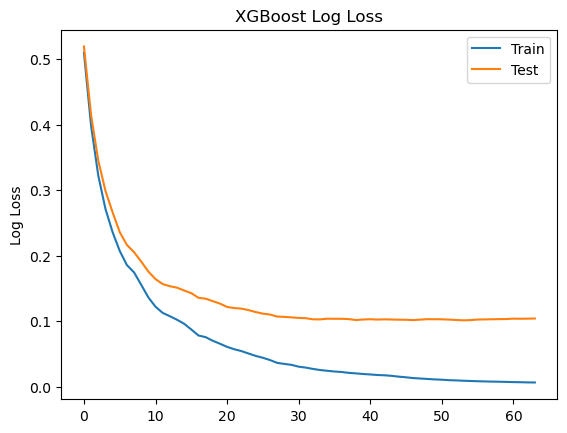

In [22]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Extract the best parameters
best_params = opt.best_params_

# Manually fit an XGBoost model with these parameters and early stopping
model = XGBClassifier(**best_params)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

# Retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()



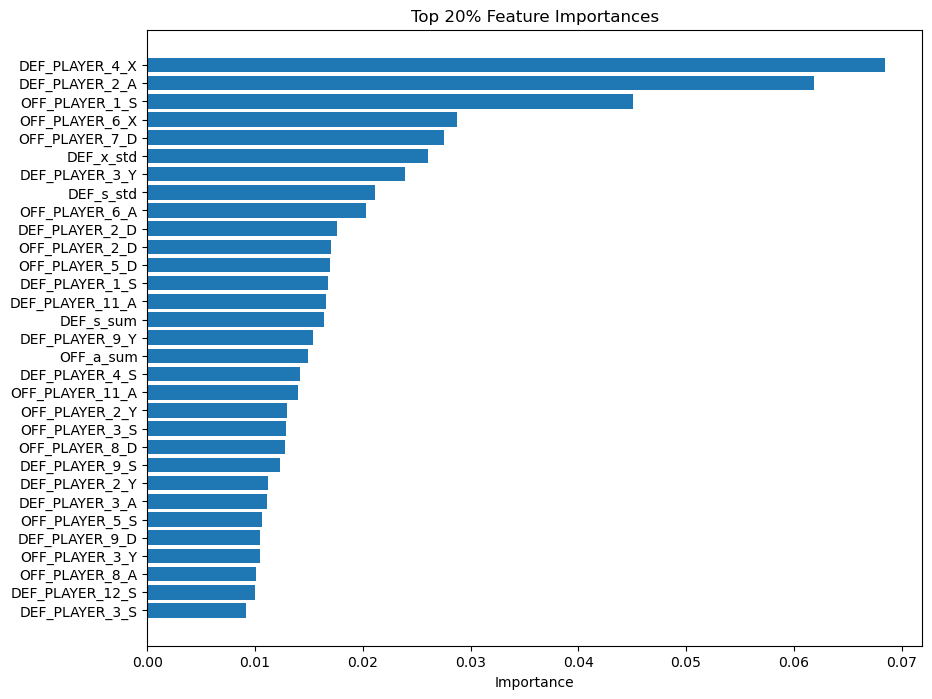

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'model' is your trained XGBoost model
importance = model.feature_importances_

# Convert to a DataFrame
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importance})

# Sort by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select the top 20% of the features
top_20_percent = int(len(feature_importance) * 0.2)
top_features = feature_importance.head(top_20_percent)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 20% Feature Importances')
plt.gca().invert_yaxis()  # To display the highest bar at the top
plt.show()



In [49]:
# Join predictions with identifiers
test_with_proba = identifiers.loc[X_test.index].copy()  # use loc to match the indices
test_with_proba['predicted_probability'] = y_pred_proba

# Convert probabilities to percentages
test_with_proba['predicted_probability'] = test_with_proba['predicted_probability'].apply(lambda x: round(x * 100, 2))

# Now test_with_proba contains the game, play, frame IDs, and the predicted probabilities as percentages
print(test_with_proba)
# Define the file path and name
file_path = "/Users/nick/nfl-big-data-bowl-2024/predicted_contact_or_tackle_probability_by_frame.csv"

# Save the DataFrame as a CSV file
test_with_proba.to_csv(file_path, index=False)

# Print a message to confirm the file has been saved
print(f"DataFrame saved as '{file_path}'")


          gameId  playId  frameId  contact_or_tackle_happened  \
1966  2022091101    1616       53                           0   
2857  2022091101    2386       42                           0   
4326  2022091101    3287       34                           1   
3558  2022091101    2832       18                           1   
3213  2022091101    2501       33                           0   
...          ...     ...      ...                         ...   
5270  2022091101    3789       55                           1   
527   2022091101     361       14                           0   
3903  2022091101    3080       22                           1   
3616  2022091101    2909       37                           0   
1765  2022091101    1564       58                           1   

      predicted_probability  
1966                   0.02  
2857                   0.30  
4326                  99.28  
3558                  99.07  
3213                   0.29  
...                     ...  
5270     

In [24]:
import matplotlib.pyplot as plt

# Extract the predicted probabilities
predicted_probabilities = test_with_proba['predicted_probability']

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(predicted_probabilities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probabilities (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


NameError: name 'test_with_proba' is not defined

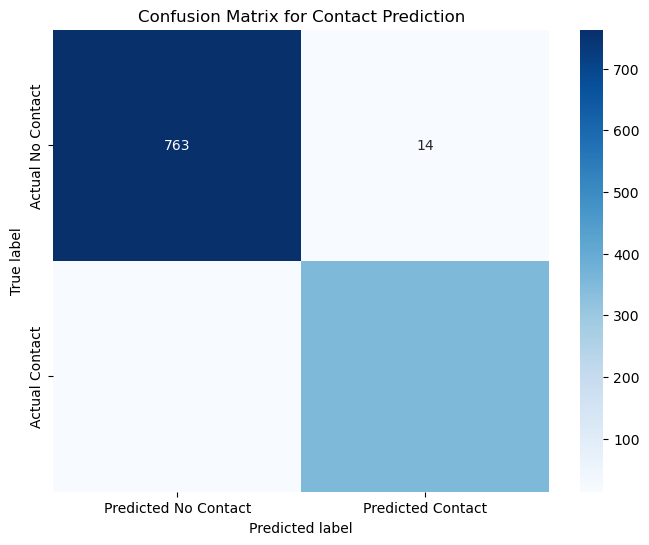

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred)

# Define the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted No Contact", "Predicted Contact"],
            yticklabels=["Actual No Contact", "Actual Contact"])

# Add labels and title for clarity
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Contact Prediction')

# Show the plot
plt.show()

In [55]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, roc_auc_score

# # Split data into features (X) and target (y)
# X = final_df[features_list]
# y = final_df['contact_or_tackle_happened']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define SMOTE and RandomUnderSampler in a pipeline
# over = SMOTE(sampling_strategy=0.1)  # Adjust the sampling_strategy as needed
# under = RandomUnderSampler(sampling_strategy=0.5)
# pipeline = Pipeline([('o', over), ('u', under)])

# # Apply the pipeline to resample X_train and y_train
# X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# # Initialize XGBoost with class weight (adjust as needed or remove)
# scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
# xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)

# # Train the model on the resampled training data
# xgb_model.fit(X_train_resampled, y_train_resampled)

# # Predict and evaluate on the original test set
# y_pred = xgb_model.predict(X_test)
# y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
# print(classification_report(y_test, y_pred))
# print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")

In [56]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
# Extract features and target
X = final_df[features_list]  # Replace features_list with your actual list of features
y = final_df['contact_or_tackle_happened']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter if convergence issues arise
log_reg.fit(X_train, y_train)
# Get predicted probabilities for the positive class
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

# Sort the probabilities in descending order
sorted_proba = np.sort(y_pred_proba)[::-1]

# Find a threshold: this is a simple approach, you may want to refine this
num_samples = int(len(y_test) * 0.0184)  # Let's say we want the top 5% scores to be class '1'
threshold = sorted_proba[num_samples - 1]

# Apply the threshold to get the final predictions
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
# Print classification report for the adjusted threshold
print(classification_report(y_test, y_pred_adjusted))

# AUC-ROC Score
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       777
           1       0.86      0.05      0.10       367

    accuracy                           0.69      1144
   macro avg       0.78      0.52      0.46      1144
weighted avg       0.75      0.69      0.58      1144

AUC-ROC Score: 0.7232105597228213


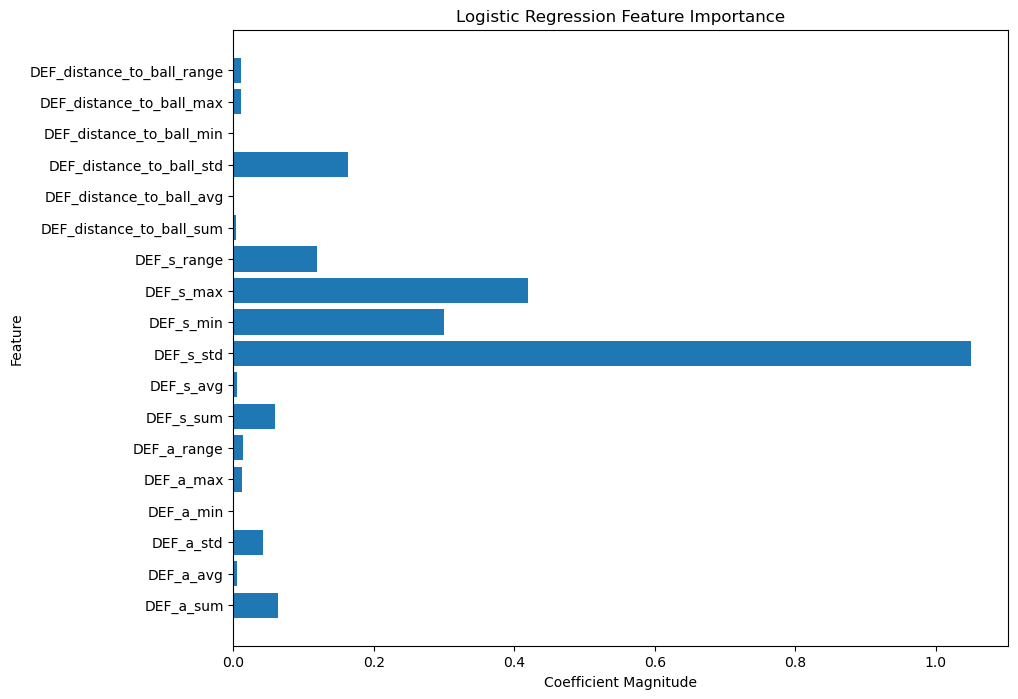

In [57]:
import numpy as np

# Assuming your logistic regression model is named log_reg and is already trained
log_reg_coef = np.abs(log_reg.coef_[0])  # Taking absolute value for magnitude

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(features_list)), log_reg_coef, align='center')
plt.yticks(range(len(features_list)), features_list)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importance')
plt.show()
